In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

In [10]:
def euler(ro0, V, h):
    n = np.size(ro0)
    ro = 0* ro0
    for i in range(n):
        ro[i] = ro0[i] + V(ro0[i])*h
    return ro

def Mro(ro,f):
    # ro = matrices de forme (n,d) contenant les coordonnées des n particules qui donne la mesure empirique
    # f fonction donnée par le problème
    # M matrice d'information
    (n1,n2) = ro.shape
    n = np.size(f(1))
    M = np.zeros((n,n))
    for i in range(n1):
        X = f(ro[i])
        M = M + np.dot(X,X.T)
    M = M/n1
    invM = np.linalg.inv(M)
    return M, invM

def Vt (f , df, invM, sigma = 0):
    Vt = lambda x: 2*(x<=1)*(x>=0)*df(x).dot(invM).dot(f(x)) + sigma*rand.normal()
    return Vt

def flow(ro0, f, df, h, nt, sigma = 0):
    ro = ro0
    for i in range(nt):
        M, invM = Mro(ro,f)
        V = Vt(f, df, invM, sigma)
        ro = euler(ro, V, h)
    return ro

f = lambda x : np.array([x ,x**2, x**3])

df = lambda x : np.array([1, 2*x, 3*x**2])


#### $\sigma = 0$, $ h= 0.0002 $, 50000 pas, 100 particules

In [17]:
nt = 50000
h= 0.0002
sigma = 0 # mettre sigma à 0 pour ne pas ajouter d'entropie
f = lambda x : np.array([x ,x**2, x**3])
df = lambda x : np.array([1, 2*x, 3*x**2])
ro = np.array([np.linspace(0,1,100)]).T
M, invM = Mro(ro,f)
rof = flow(ro, f, df, h, nt, sigma)
print(rof)

[[0.        ]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.27987901]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73234024]
 [0.73

(array([ 1.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 39.,  0.,  0.,  0.,  0., 15.]),
 array([0.        , 0.05196799, 0.10393598, 0.15590397, 0.20787196,
        0.25983995, 0.31180795, 0.36377594, 0.41574393, 0.46771192,
        0.51967991, 0.5716479 , 0.62361589, 0.67558388, 0.72755187,
        0.77951986, 0.83148786, 0.88345585, 0.93542384, 0.98739183,
        1.03935982]),
 <a list of 20 Patch objects>)

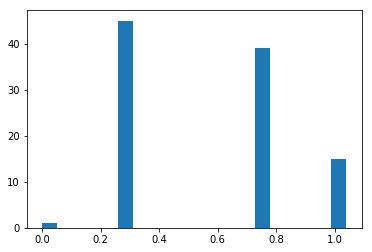

In [18]:
plt.hist(rof,bins = 20)

#### 10 particules

[[0.        ]
 [0.28051938]
 [0.28051938]
 [0.28051938]
 [0.28051938]
 [0.73403508]
 [0.73403508]
 [0.73403508]
 [1.00580237]
 [1.02209322]]


(array([1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
        0., 0., 2.]),
 array([0.        , 0.05110466, 0.10220932, 0.15331398, 0.20441864,
        0.25552331, 0.30662797, 0.35773263, 0.40883729, 0.45994195,
        0.51104661, 0.56215127, 0.61325593, 0.6643606 , 0.71546526,
        0.76656992, 0.81767458, 0.86877924, 0.9198839 , 0.97098856,
        1.02209322]),
 <a list of 20 Patch objects>)

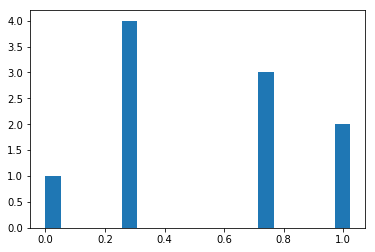

In [11]:
nt = 50000
h= 0.0002
sigma = 0
ro1 = np.array([np.linspace(0,1,10)]).T
M, invM = Mro(ro1,f)
rof1 = flow(ro1, f, df, h, nt, sigma)
print(rof1)
plt.hist(rof1,bins = 20)

#### 10 particules, sigma = 1

[[0.29801173]
 [0.29413879]
 [0.29518832]
 [0.29467096]
 [0.29517897]
 [0.29600839]
 [0.29749835]
 [0.29679158]
 [0.29629368]
 [0.77273865]
 [0.77342191]
 [0.77206972]
 [0.77391168]
 [0.7742196 ]
 [0.77452119]
 [0.77289564]
 [0.77479493]
 [1.03280277]
 [1.07011613]
 [1.09250468]]


(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 5., 0., 0., 0., 0.,
        0., 1., 2.]),
 array([0.29413879, 0.33405708, 0.37397538, 0.41389367, 0.45381197,
        0.49373026, 0.53364855, 0.57356685, 0.61348514, 0.65340344,
        0.69332173, 0.73324003, 0.77315832, 0.81307662, 0.85299491,
        0.89291321, 0.9328315 , 0.9727498 , 1.01266809, 1.05258639,
        1.09250468]),
 <a list of 20 Patch objects>)

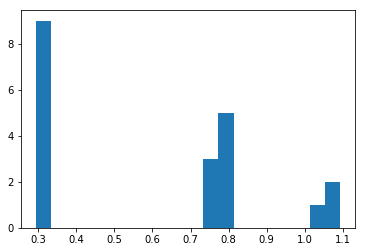

In [15]:
sigma = 1
ro1 = np.array([np.linspace(0,1,20)]).T
M, invM = Mro(ro1,f)
rof2 = flow(ro1, f, df, h, nt, sigma)
print(rof2)
plt.hist(rof2,bins = 20)

#### 50 particules, sigma = 1

[[0.2907181 ]
 [0.29485338]
 [0.28989413]
 [0.28903836]
 [0.29212156]
 [0.29086696]
 [0.29265098]
 [0.29365384]
 [0.28948865]
 [0.29193443]
 [0.29296641]
 [0.29127195]
 [0.29289965]
 [0.29298415]
 [0.29024437]
 [0.29302311]
 [0.2933456 ]
 [0.29068846]
 [0.29127206]
 [0.29095419]
 [0.29182915]
 [0.28963518]
 [0.29214314]
 [0.75909114]
 [0.7605562 ]
 [0.76005008]
 [0.75892722]
 [0.7630417 ]
 [0.76138328]
 [0.76130087]
 [0.75865333]
 [0.76346908]
 [0.76003106]
 [0.7605104 ]
 [0.76089074]
 [0.76015472]
 [0.76314674]
 [0.76325651]
 [0.76324779]
 [0.75921859]
 [0.76149541]
 [0.7614621 ]
 [1.03877643]
 [1.021322  ]
 [1.07426471]
 [1.0100553 ]
 [1.06038604]
 [1.01783017]
 [1.08665603]
 [1.0678529 ]]


(array([23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  0.,
         0.,  0.,  0.,  0.,  0.,  4.,  4.]),
 array([0.28903836, 0.32891924, 0.36880012, 0.40868101, 0.44856189,
        0.48844277, 0.52832366, 0.56820454, 0.60808543, 0.64796631,
        0.68784719, 0.72772808, 0.76760896, 0.80748984, 0.84737073,
        0.88725161, 0.9271325 , 0.96701338, 1.00689426, 1.04677515,
        1.08665603]),
 <a list of 20 Patch objects>)

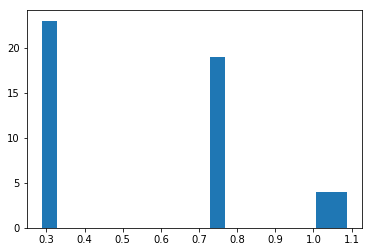

In [16]:
sigma = 1
ro1 = np.array([np.linspace(0,1,50)]).T
M, invM = Mro(ro1,f)
rof2 = flow(ro1, f, df, h, nt, sigma)
print(rof2)
plt.hist(rof2,bins = 20)

#### On deplace la masse un peu vers la droite (loi uniforme sur $[0.5, 1]$), 20 particules $\sigma =0$

[[0.27994099]
 [0.27994099]
 [0.27994099]
 [0.27994099]
 [0.27994099]
 [0.27994099]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [0.73213145]
 [1.00327607]
 [1.00480436]
 [1.00333894]
 [1.01026495]
 [1.03348121]]


(array([6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0.,
        0., 0., 5.]),
 array([0.27994099, 0.317618  , 0.35529501, 0.39297202, 0.43064903,
        0.46832605, 0.50600306, 0.54368007, 0.58135708, 0.61903409,
        0.6567111 , 0.69438811, 0.73206512, 0.76974213, 0.80741915,
        0.84509616, 0.88277317, 0.92045018, 0.95812719, 0.9958042 ,
        1.03348121]),
 <a list of 20 Patch objects>)

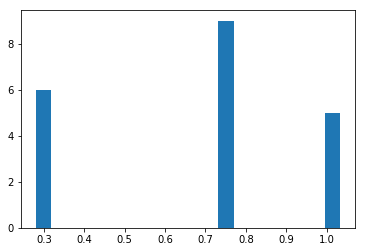

In [17]:
sigma = 0
ro05 = np.array([np.linspace(0.5,1,20)]).T
M, invM = Mro(ro05,f)
rof05 = flow(ro05, f, df, h, nt, sigma)
print(rof05)
plt.hist(rof05,bins = 20)

#### 50 particules $\sigma = 0$

[[0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [1.00426402]
 [1.00436382]
 [1.00367368]
 [1.00832025]
 [1.00130654]
 [1.00065608]
 [1.00944209]
 [1.00481372]
 [1.00870619]
 [1.00576094]
 [1.02194874]
 [1.03901009]]


(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., 11.]),
 array([0.27937343, 0.31735526, 0.35533709, 0.39331893, 0.43130076,
        0.46928259, 0.50726443, 0.54524626, 0.58322809, 0.62120992,
        0.65919176, 0.69717359, 0.73515542, 0.77313726, 0.81111909,
        0.84910092, 0.88708276, 0.92506459, 0.96304642, 1.00102825,
        1.03901009]),
 <a list of 20 Patch objects>)

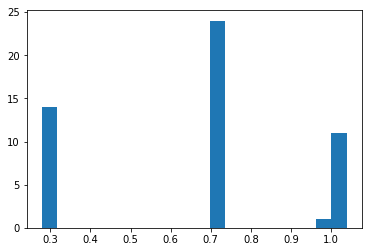

In [18]:
sigma = 0
ro05 = np.array([np.linspace(0.5,1,50)]).T
M, invM = Mro(ro05,f)
rof05 = flow(ro05, f, df, h, nt, sigma)
print(rof05)
plt.hist(rof05,bins = 20)

#### Sigma = 2

[[0.29089967]
 [0.29446299]
 [0.2878807 ]
 [0.29023408]
 [0.28896077]
 [0.29200348]
 [0.75676707]
 [0.75673971]
 [0.7587475 ]
 [0.75503464]
 [0.75265517]
 [0.75343222]
 [0.75625332]
 [0.75302135]
 [0.75194162]
 [1.028451  ]
 [1.00351554]
 [1.03273808]
 [1.08999199]
 [1.0383089 ]]


(array([6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0.,
        1., 3., 1.]),
 array([0.2878807 , 0.32798626, 0.36809183, 0.40819739, 0.44830296,
        0.48840852, 0.52851409, 0.56861965, 0.60872522, 0.64883078,
        0.68893635, 0.72904191, 0.76914748, 0.80925304, 0.8493586 ,
        0.88946417, 0.92956973, 0.9696753 , 1.00978086, 1.04988643,
        1.08999199]),
 <a list of 20 Patch objects>)

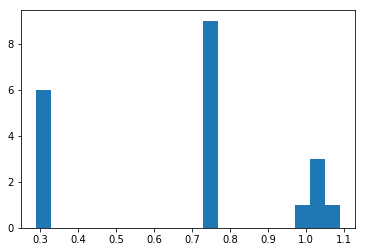

In [24]:
sigma = 2
ro05 = np.array([np.linspace(0.5,1,20)]).T
M, invM = Mro(ro05,f)
rof05 = flow(ro05, f, df, h, nt, sigma)
print(rof05)
plt.hist(rof05,bins = 20)

#### masse un peu plus sur la droite ($[0.7,1]$)

[[0.28112129]
 [0.28112129]
 [0.28112129]
 [0.28112129]
 [0.28112129]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [0.73415416]
 [1.0051537 ]
 [1.00038858]
 [1.00868447]
 [1.00566913]
 [1.01374969]
 [1.04770952]]


(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0.,
        0., 4., 2.]),
 array([0.28112129, 0.3194507 , 0.35778011, 0.39610952, 0.43443893,
        0.47276835, 0.51109776, 0.54942717, 0.58775658, 0.62608599,
        0.6644154 , 0.70274481, 0.74107423, 0.77940364, 0.81773305,
        0.85606246, 0.89439187, 0.93272128, 0.97105069, 1.00938011,
        1.04770952]),
 <a list of 20 Patch objects>)

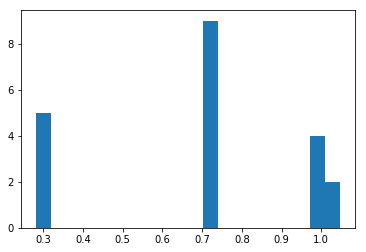

In [25]:
sigma = 0
ro07 = np.array([np.linspace(0.7,1,20)]).T
M, invM = Mro(ro07,f)
rof07 = flow(ro07, f, df, h, nt, sigma)
print(rof07)
plt.hist(rof07,bins = 20)

[[0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.27937343]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [0.73080666]
 [1.00426402]
 [1.00436382]
 [1.00367368]
 [1.00832025]
 [1.00130654]
 [1.00065608]
 [1.00944209]
 [1.00481372]
 [1.00870619]
 [1.00576094]
 [1.02194874]
 [1.03901009]]


(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., 11.]),
 array([0.27937343, 0.31735526, 0.35533709, 0.39331893, 0.43130076,
        0.46928259, 0.50726443, 0.54524626, 0.58322809, 0.62120992,
        0.65919176, 0.69717359, 0.73515542, 0.77313726, 0.81111909,
        0.84910092, 0.88708276, 0.92506459, 0.96304642, 1.00102825,
        1.03901009]),
 <a list of 20 Patch objects>)

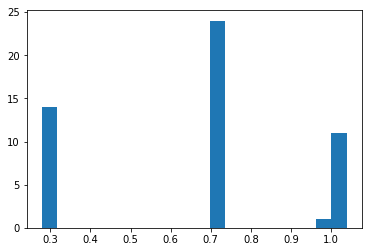

In [26]:
sigma = 0
ro05 = np.array([np.linspace(0.5,1,50)]).T
M, invM = Mro(ro05,f)
rof05 = flow(ro05, f, df, h, nt, sigma)
print(rof05)
plt.hist(rof05,bins = 20)